In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.special import comb
from scipy.stats import rankdata, pearsonr
from sklearn import linear_model
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import colors as COLORS

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from scipy.special import comb
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, Layout
from IPython import display

import loc_utils as lut
import vis_utils as vut
from standards import *

rx = RAWXix()
r = RAWix()
gcolors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']
colors = ['#375e97', '#f18d9e', '#ffbb00', '#3f681c']
glabels = {0: 'F', 1: 'S'}
clabels = {0: 'i-', 1: 'i+'}

def gclabel(g, c):
    return '{}/{}'.format(glabels[g], clabels[c])

tlabels = {
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'R'}

saveloc = '/Users/alexten/Projects/HFSP/img'
desktop = '/Users/alexten/Desktop/'

data_path = 'pipeline_data/s3/joint_data.pkl'

def save_it(fig, savedir, figname, save_as='svg', dpi=500, compress=True):
    s = savedir+'/{}.{}'.format(figname, save_as)
    fig.savefig(s, format=save_as, dpi=500)
    if compress:
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))
        
def onehot(ind):
    ind = ind - 1
    onehots = np.zeros([ind.size, 4])
    onehots[np.arange(ind.size), ind] = 1
    return onehots


def run_MNlog(x, y, pivot, fullout=0):
    y = y.replace(to_replace=pivot, value=0, inplace=False)
    mdl = sm.MNLogit(y, x)
    mdl_fit = mdl.fit(maxiter=100, full_output=fullout)
    return mdl_fit

def run_skl_MNlog(x, y, pivot):
    # y = y.replace(to_replace=pivot, value=0, inplace=False)
    mdl = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
    mdl_fit = mdl.fit(x, y)
    return mdl_fit


def softmax(x, stable=0):
    """Compute softmax values for each sets of scores in x."""
    if stable:
        e_x = np.exp(x - np.max(x, axis=0))
        return e_x / e_x.sum(axis=0)
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def add_text(ax, arr):
    for (j, i), label in np.ndenumerate(arr):
        ax.text(i, j, label, ha='center', va='center')
        
# cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,sw_pred,sw_act,sw_lag'.split(',')
# ix = cols.index

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Model prototype

## Prepare data

Look at the accuracy of your switch predictions as a function of how far they are from the last switch that the person made. For this, take the switch predictions that do not involve a dip below the learning threshold (easier to interpret!). Then assign each switch prediction to a “lag” relative to the last task switch the person made. For instance, if the person just switched tasks on trial 10, and your prediction is that he should switch again on trial 11, this switch command has a lag of 1 trial; if your prediction was that he should switch again on trial 12, this has a lag of 2 trials; and so on. Plot the % of switch predictions that were obeyed as a function of lag. This will give you an estimate of how long after a switch people need in order to switch again.

## Model switches

In [ ]:
def self_challenging_data(path, alpha=.01, null=.5, save_as=False):
    def p_val(n, k, p):
        return comb(n,k) * p**k * (1-p)**(n-k)

    mdata = lut.unpickle(path)['main']
    sids, groups, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'),r.ix('cat')])

    nontest = freeplay = lut.get_mask(mdata, {r.ix('stage'): 2}, '!=')
    mdata = mdata[nontest, :]

    outdata = []
    cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,sw_pred,sw_act,sw_lag'.split(',')
    ix = cols.index

    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        
        for sid in gsids:
            sdata = mdata[lut.get_mask(mdata, {r.ix('sid'): sid}), :]
            sid_data = np.zeros([sdata.shape[0]-1, len(cols)])
            
            # fill in task on next trial
            sid_data[:, ix('t1')] = sdata[:, r.ix('cat')][1:]
            
            # discard the last trial completely
            sdata = sdata[:-1, :]
            
            # fill in group, sid, stage, and actual switches
            sid_data[:,ix('sid')] = sdata[:, r.ix('sid')]
            sid_data[:,ix('grp')] = grp
            sid_data[:,ix('stage')] = sdata[:, r.ix('stage')]
            sid_data[:-1,ix('sw_act')] = sdata[:, r.ix('switch')][1:]
            sid_data[:60,ix('sw_act')] = 0
            
            # fill in trial numbers and block trial numbers
            sid_data[:, ix('trial')] = sdata[:, r.ix('trial')]
            sid_data[:, ix('blkt')] = sdata[:, r.ix('blkt')]
            
            # fill in task on current trial
            sid_data[:, ix('t0')] = sdata[:, r.ix('cat')]
            
            for ti, tsk in enumerate(tasks):
                tmask = lut.get_mask(sdata, {r.ix('cat'): tsk})
                
                trials_so_far = np.cumsum(tmask)
                cor_on_task = np.zeros(sid_data.shape[0])
                cor_on_task[tmask] = sdata[tmask, r.ix('cor')]
                cor_so_far = np.cumsum(cor_on_task)
                
                with np.errstate(divide='ignore', invalid='ignore'):
                    sid_data[:, ix('pc{}'.format(tsk))] = cor_so_far / trials_so_far
                    sid_data[:, ix('p{}'.format(tsk))] = p_val(
                        trials_so_far, cor_so_far, null)
            sid_data = sid_data[58:]

            pcs = sid_data[:, ix('pc1'):ix('p1')].copy()
            pvals = sid_data[:, ix('p1'):ix('sc1')]
            
            t1 = sid_data[:, ix('t1')].astype(int)-1
            t0 = sid_data[:, ix('t0')].astype(int)-1
            
            actual_next_choice = np.zeros([sid_data.shape[0], 4]).astype(bool)
            actual_next_choice[np.arange(t1.size), t1] = True
            
            learnt = np.logical_and(pvals < alpha, pcs > null)
            learnt_pcs = pcs.copy()
            learnt_pcs[learnt] -= 1
            predicted_pc = sid_data[
                np.arange(sid_data.shape[0]), 
                ix('pc1')+np.argmax(learnt_pcs, axis=1)]
            
            sid_data[1:, ix('sw_pred')] = np.logical_not(
                t0[1:]==np.argmax(pcs, axis=1)[:-1])
            
            sw_lag_mask = np.logical_and(
                sid_data[:, ix('sw_pred')], pvals[np.arange(t0.size), t0] >= alpha)
            sid_data[:, ix('sw_lag')] = sid_data[:, ix('blkt')]
            sid_data[:2, ix('sw_lag')], sid_data[:, ix('sw_lag')][~sw_lag_mask] = np.nan, np.nan
            
            all_four = np.all(learnt, axis=1)
            for tsk in tasks:
                sid_data[all_four, ix('sc{}'.format(tsk))] = np.nan
            sid_data[all_four, ix('sw_pred')] = np.nan
            
            sid_data[1:, ix('sc1'):ix('sc4')+1] = predicted_pc[1:].reshape([-1,1]) - pcs[1:]
            
            outdata.append(sid_data[1:])
            
#             if grp == 0 and sid == 72:
#                 sid_data = sid_data[1:]
#                 fig = plt.figure(300)
#                 ax = fig.add_subplot(111)
#                 m = np.logical_and(sid_data[:, ix('sw_act')].astype(bool), sid_data[:, ix('sw_pred')].astype(bool))
#                 mm = ~np.isnan(sid_data[:, ix('sw_lag')]) & m
#                 trials = np.nonzero(mm)
#                 lags = sid_data[:, ix('sw_lag')][mm]
#                 print('Lags: {}\nTrials: {}'.format(lags, trials))
#                 ax.set_color_cycle(colors)
#                 ax.plot(sid_data[:, ix('pc1'):ix('pc4')+1])
#                 ax.plot(sid_data[:, ix('p1'):ix('p4')+1], ls='--')
#                 ax.vlines(np.nonzero(~np.isnan(sid_data[:, ix('sw_lag')])),0,1,color='purple', alpha=.4)
#                 ax.plot(sid_data[:, ix('sw_act')], ls='', c='cyan', marker='s',alpha=.5)
#                 ax.plot(np.arange(m.size),m, ls='', marker='|', color='k', alpha=.5)
            
            
    outdata = np.vstack(outdata)
    
    if save_as:
        lut.dopickle(save_as, outdata)

        
if 1:
    save_as = 'pipeline_data/scdata/modeling_data_sw_lag.pkl'
    
    self_challenging_data(path='pipeline_data/s3/joint_data.pkl',
                      save_as=save_as)

# cyan squares = actual switches
# purple vertical lines = lagging trials
# black ticks = prediction obeying switches

## Visualize swithcing as a function of lag
### Switch lag distributions

In [ ]:
def view_switching_vs_lag(path, figname):
    data = lut.unpickle(path)
    
    cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,sw_pred,sw_act,sw_lag'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3,4]
    
    fig = plt.figure(num=figname)
    ax = fig.add_subplot(111)
    
    all_lags = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for gsid in gsids:
            smask = lut.get_mask(data, {ix('sid'): gsid})
            sid_data = data[smask, :]

            m = np.logical_and(sid_data[:, ix('sw_act')].astype(bool), sid_data[:, ix('sw_pred')].astype(bool))
            mm = ~np.isnan(sid_data[:, ix('sw_lag')]) & m

            if np.any(mm):
                all_lags.append(sid_data[:, ix('sw_lag')][mm].mean())
        
        vut.line_histogram(ax, np.array(all_lags), np.arange(0,250,10), glabels[grp], lw=2, c=gcolors[grp])
    ax.legend()
    ax.set_title('Switch lags seem similar ')

    
def view_switching_vs_lag_boxplot(path, figname):
    data = lut.unpickle(path)
    
    cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,sw_pred,sw_act,sw_lag'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3,4]
    
    fig = plt.figure(num=figname)
    ax = fig.add_subplot(111)
    
    test_data = []
    for grp in groups:
        glags = []
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for gsid in gsids:
            smask = lut.get_mask(data, {ix('sid'): gsid})
            sid_data = data[smask, :]

            m = np.logical_and(sid_data[:, ix('sw_act')].astype(bool), sid_data[:, ix('sw_pred')].astype(bool))
            mm = ~np.isnan(sid_data[:, ix('sw_lag')]) & m
            
            if np.any(mm):
                glags.append(sid_data[:, ix('sw_lag')][mm].mean())
        
        test_data.append(glags)
        gmean = np.mean(glags)
        gsem = stats.sem(glags)
        ax.bar(grp, gmean, yerr=gsem, align='center', facecolor=gcolors[grp],
               ecolor='k', capsize=10, label=glabels[grp])

    ax.set_xticks(groups)
    ax.set_xticklabels(['Free', 'Strategic'])
    ax.set_title('Switch lags are smaller in Strategic group (alt)')
    ax.grid(True, linestyle=':', c='gray', zorder=0)
    vut.despine(ax, ['top','right'])
    
    W, levene = stats.levene(test_data[0], test_data[1], center='mean')
    print(W,levene, np.var(test_data[0]), np.var(test_data[1]))
    print(stats.ttest_ind(test_data[0], test_data[1], equal_var=levene >= .05))
    
if 1:
    view_switching_vs_lag('pipeline_data/scdata/modeling_data_sw_lag.pkl', figname = 'switching_and_lag')
    
    view_switching_vs_lag_boxplot('pipeline_data/scdata/modeling_data_sw_lag.pkl', figname = 'switching_and_lag_bars')

## Average streak lengths

In [ ]:
def view_streak_lengths(path, figname):
    data = lut.unpickle(path)
    
    cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,sw_pred,sw_act,sw_lag'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3,4]
    
    fig = plt.figure(num=figname)
    ax = fig.add_subplot(111)
    
    test_data = []
    for grp in groups:
        streaks = []
        mean_streaks = []
        
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask, :], ix('sid'))
        for gsid in gsids:
            smask = lut.get_mask(data, {ix('sid'): gsid})
            sid_data = data[smask, :]
            
            switch = sid_data[:, ix('sw_act')].astype(bool)
            streaks += sid_data[:, ix('blkt')][switch].tolist()
            
            mean_streaks.append(np.mean(sid_data[:, ix('blkt')][switch]))
            
        test_data.append(streaks)
        gmean = np.mean(streaks)
        gsem = stats.sem(streaks)
        ax.bar(grp, gmean, yerr=gsem, align='center', facecolor=gcolors[grp],
               ecolor='k', capsize=10, label=glabels[grp])

    ax.set_xticks(groups)
    ax.set_xticklabels(['Free', 'Strategic'])
    ax.set_title('Streak lengths by group')
    ax.grid(True, linestyle=':', c='gray', zorder=0)
    vut.despine(ax, ['top','right'])
    
    print(np.var(test_data[0]), np.var(test_data[1]))
    print(stats.ttest_ind(test_data[0], test_data[1]))
    
    
if 1:
    view_streak_lengths('pipeline_data/scdata/modeling_data_sw_lag.pkl', figname='streak lengths')

In [ ]:
def sigm(x):
    return (1)/(1 + np.exp(-x))

def pval_on_switch(path, subj, k):
    np.set_printoptions(suppress=True)
    data = lut.unpickle(path)
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    
    # fig = plt.figure('pvals_n_switches', figsize=[7,4])
    # ax = fig.add_subplot(111)
    
    for grp in groups[:1]:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask, :], ix('sid'))
        
        bs = []
        for sid in gsids[subj:subj+1]:
            smask = lut.get_mask(data, {ix('sid'): sid})
            nrows = smask.sum()
            
            switch_trials = data[smask, ix('sw_act')].astype(int)
            
            blkt = data[smask, ix('blkt')]
            pvals = data[smask, ix('p1'):ix('sc')]

            t0 = data[smask, ix('t0')] - 1

            pvals = pvals[np.arange(nrows), t0.astype(int)]
            
            Y = switch_trials[:k].reshape([-1, 1])
            
            # Only pvals
            X = pvals[:k].reshape([-1, 1])*100
            X = sm.add_constant(X)
            logit_model = sm.Logit(Y, X)
            try:
                results = logit_model.fit(disp=0)
            except np.linalg.LinAlgError as err:
                continue
            print(results.summary())
            
            # Only blkt
            X = blkt[:k].reshape([-1, 1])
            X = sm.add_constant(X)
            logit_model = sm.Logit(Y, X)
            try:
                results = logit_model.fit(disp=0)
            except np.linalg.LinAlgError as err:
                continue
            print(results.summary())

            # pvals and blkt
            X = np.stack([blkt[:k], pvals[:k]*100], axis=1)
            X = sm.add_constant(X)
            logit_model = sm.Logit(Y, X)
            try:
                results = logit_model.fit(disp=0)
            except np.linalg.LinAlgError as err:
                continue
            print(results.summary())
            
#             x = np.sum(
#                 np.stack([bi*xi for bi, xi in zip(results.params, X.T)], axis=0), axis=0)
#             y = sigm(x)

#             inds = np.arange(k)
#             ax2.plot(inds,y, c=gcolors[1], lw=1, marker='o', markersize=2, alpha=.5)
#             ax2.plot(inds,pvals[:k], c=gcolors[0], lw=1)
#             for i in inds[switch_trials.astype(bool)[:k]]:
#                 ax2.axvline(i, c='k', alpha=.2, zorder=0)
#             error = np.mean((y-Y.squeeze())**2)

#             print('Mean squared error =', error)
#             for p, ci in zip(results.params, results.conf_int()):
#                 print(np.exp(p), np.exp(ci))
            
#     pvals = data[np.arange(data.shape[0]), data[ix('p1')+ix('t0')-1].astype(int)]




if 1:
    pval_on_switch('pipeline_data/scdata/modeling_data.pkl', 8, 250)

## Model choices

82


<IPython.core.display.Javascript object>


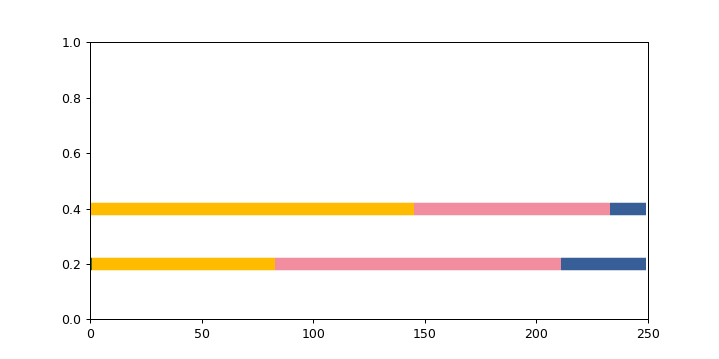

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='pc', layout=Layout(width='400px'), max=10.0, min=-10.0), FloatSlider(value=1.0, continuous_update=False, description='ch', layout=Layout(width='400px'), max=10.0, min=-10.0), FloatSlider(value=1.0, continuous_update=False, description='relt', layout=Layout(width='400px'), max=10.0, min=-10.0), Output()), _dom_classes=('widget-interact',))

In [3]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=axis).reshape([-1,1]))
    return e_x / e_x.sum(axis=axis).reshape([-1,1])


def get_vars(path, subj, k, figname=''):
    
    cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,switch,sw_act'.split(',')
    ix = cols.index
    
    np.set_printoptions(suppress=True, threshold=5000)
    data = lut.unpickle(path)
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    
    smask = lut.get_mask(data, {ix('sid'): subj})
    sdata = data[smask, :][:k]

    pc  = sdata[:, ix('pc1'):ix('pc4')+1]
    ch  = sdata[:, ix('sc1'):ix('sc4')+1]
    rts = np.zeros_like(pc)
    for j, tsk in enumerate([1,2,3,4]):
        tmask = lut.get_mask(sdata, {ix('t0'): tsk})
        rts[tmask, j] = 1
    rts[0, :] = 15
    rts = np.cumsum(rts, axis=0)
    rts = np.transpose(rts.T / np.sum(rts, axis=1))
    
    return pc, ch, rts, sdata
                

def get_vars2(path, subj, k, figname=''):
    
    cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,switch,sw_act'.split(',')
    ix = cols.index
    
    np.set_printoptions(suppress=True, threshold=5000)
    data = lut.unpickle(path)
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    
    smask = lut.get_mask(data, {ix('sid'): subj})
    sdata = data[smask, :][:k]

    pc  = sdata[:, ix('pc1'):ix('pc4')+1]
    ch  = sdata[:, ix('sc1'):ix('sc4')+1]
    rts = np.zeros_like(pc)
    for j, tsk in enumerate([1,2,3,4]):
        tmask = lut.get_mask(sdata, {ix('t0'): tsk})
        rts[tmask, j] = 1
    rts[0, :] = 15
    rts = np.cumsum(rts, axis=0)
    rts = np.transpose(rts.T / np.sum(rts, axis=1))
    
    return pc, ch, rts, sdata


def update(lc, x1, x2, x3, b1, b2, b3):
    lincomb = b1*x1 + b2*x2 + b3*x3
    v = softmax(lincomb, 1)
    ptskv = np.argmax(v, axis=1)
    lc_pred.set_array(ptskv)
    fig.canvas.draw()


cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,switch,sw_act'.split(',')
ix = cols.index

if 1:
    path = 'pipeline_data/scdata/modeling_data_sc_by_task.pkl'
    lim = 250
    sid = np.random.randint(0,150)
    print(sid)
    
    x1, x2, x3, raw = get_vars(path, sid, lim)
    style = {'width': '80%'}
    b1 = widgets.FloatSlider(value=1, min=-10, max=10, step=.1, description='pc', continuous_update=False, layout=Layout(width='400px'))
    b2 = widgets.FloatSlider(value=1, min=-10, max=10, step=.1, description='ch', continuous_update=False, layout=Layout(width='400px'))
    b3 = widgets.FloatSlider(value=1, min=-10, max=10, step=.1, description='relt', continuous_update=False, layout=Layout(width='400px'))
    
    fig = plt.figure('Interactive model', figsize=[8,4])
    ax = fig.add_subplot(111)
    ax.set_xlim(0, lim)
    ax.set_ylim(0, 1)
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(range(5), cmap.N)
    
    
    tskv = raw[:, ix('t0')]-1
    ypos = np.zeros(lim)
    inds = np.arange(lim)
    
    points = np.array([inds, ypos+.2]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc_act = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm, linewidth=10)
    lc_act.set_array(tskv)
    ax.add_collection(lc_act)
    
    points = np.array([inds, ypos+.4]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc_pred = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm, linewidth=10)

    lincomb = b1.value*x1 + b2.value*x2 + b3.value*x3
    v = softmax(lincomb, 1)
    ptskv = np.argmax(v, axis=1)
    lc_pred.set_array(ptskv)
    ax.add_collection(lc_pred)
    
    interact(update, 
             lc=widgets.fixed(lc_pred), 
             x1=widgets.fixed(x1),
             x2=widgets.fixed(np.abs(x2)),
             x3=widgets.fixed(x3),
             b1=b1, b2=b2, b3=b3)

# Model 1

In [9]:
def model1(path):
    cols = 'sid,grp,stage,trial,blkt,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc1,sc2,sc3,sc4,switch,sw_act'.split(',')
    ix = cols.index
    
    data = lut.unpickle(path)

    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1, 2, 3, 4]

#     fig = plt.figure(num='Model summary', figsize=[12, 8])
    images = []
    
    for grp in groups[:1]:

        gmask = lut.get_mask(arr=data, conds={ix('grp'): grp})
        gdata = data[gmask, :]
        switch = gdata[:, ix('sw_act')].astype(bool)
        
        gdata = gdata[switch, :]
        
        pc = gdata[:, ix('pc1'):ix('pc4') + 1]
        ch = gdata[:, ix('sc1'):ix('sc4') + 1]
        
        blkt = gdata[:, ix('blkt')]
        rt = np.zeros_like(pc)

        for j, tsk in enumerate([1, 2, 3, 4]):
            tmask = lut.get_mask(gdata, {ix('t0'): tsk})
            rt[tmask, j] = 1

        rt[0, :] = 15
        rt = np.cumsum(rt, axis=0)
        rt = np.transpose(rt.T / np.sum(rt, axis=1))

        ind = onehot(gdata[:, ix('t0')].astype(int)).astype(bool)
        t1dv = ind[:, 0].reshape([-1, 1]).astype(float)
        t2dv = ind[:, 1].reshape([-1, 1]).astype(float)
        t3dv = ind[:, 2].reshape([-1, 1]).astype(float)
        t4dv = ind[:, 3].reshape([-1, 1]).astype(float)
        
#         pcv = pc[ind].reshape([-1, 1])*100
#         scv = ch[ind].reshape([-1, 1])*100
#         suv = blkt[ind].reshape([-1, 1])
#         rtv = rt[ind].reshape([-1, 1])*100

        x1 = pc[ind].reshape([-1, 1])*100
        x2 = ch[ind].reshape([-1, 1])*100
        x3 = rt[ind].reshape([-1, 1])*100
        x4 = blkt.reshape([-1, 1])
        
        X_array = np.concatenate([x1, x2, x3, x4, t1dv, t2dv, t3dv, t4dv], 1)
        X = sm.add_constant(X_array, prepend=False)
        X = pd.DataFrame(data=X, columns='pc,sc,rt,sl,t1,t2,t3,t4,const'.split(','))

        Y = pd.DataFrame(data=gdata[:, ix('t1')].astype(int), columns=['Choice'])

        N = 100
        exrt = np.linspace(0, 1, 265)
        expc = [.4, .6, .8, 1.0]

        softmax_weights = []
        const_mat = []
        pc_mat = []
        rt_mat = []

        z = np.zeros(X.shape[1])
        for ti, tsk in enumerate(tasks[:1]):
            model = run_MNlog(X, Y, pivot=tsk, fullout=1)
            model2 = run_skl_MNlog(X_array, Y, pivot=tsk)
            
            beta_ = model.params.T
            beta_2 = model2.coef_
            
            print(beta_2 - beta_2[0, :])
            softmax_weights.append(-np.sum(beta_, axis=1))

            beta_ = np.insert(beta_.values, ti, z, axis=0)
            const_mat.append(beta_[:, -1])
            pc_mat.append(beta_[:, 0])
            rt_mat.append(beta_[:, 1])

            # Predict
            if 0:
                logits = np.dot(beta_, X.T)
                Y_hat = np.argmax(softmax(logits, stable=1), axis=0)

            if ti > -1:
                print(model.summary())

        overall = np.stack(softmax_weights, axis=1).T
        onevrest_const = np.stack(const_mat, axis=0)
        onevrest_pc = np.stack(pc_mat, axis=0)
        onevrest_rt = np.stack(rt_mat, axis=0)

        overall = np.stack(softmax_weights, axis=1).T
        onevrest_const = np.stack(const_mat, axis=0)
        onevrest_pc = np.stack(pc_mat, axis=0)
        onevrest_rt = np.stack(rt_mat, axis=0)

#         ax2 = fig.add_subplot(2, 3, 1 + grp * 3)
#         odds = np.exp(onevrest_pc)
#         images.append(ax2.matshow(odds, aspect='equal', cmap='viridis'))
#         ax2.set_title('Group {}: OvR PC'.format('FS'[grp]), pad=20)
#         ax2.xaxis.set_ticks_position('top')
#         ax2.yaxis.set_ticks_position('left')
#         ax2.set_xticks([0, 1, 2, 3])
#         ax2.set_yticks([0, 1, 2, 3])
#         ax2.set_xticklabels('1D,I1D,2D,R'.split(','))
#         ax2.set_yticklabels('1D,I1D,2D,R'.split(','))
#         ax2.set_ylabel('Reference')
#         ax2.set_xlabel('Odds: Pr(task)/P(reference)')
#         add_text(ax2, np.around(odds, 3))

#         ax3 = fig.add_subplot(2, 3, 2 + grp * 3)
#         odds = np.exp(onevrest_rt)
#         images.append(ax3.matshow(odds, aspect='equal', cmap='viridis'))
#         ax3.set_title('Group {}: OvR RT'.format('FS'[grp]), pad=20)
#         ax3.xaxis.set_ticks_position('top')
#         ax3.yaxis.set_ticks_position('left')
#         ax3.set_xticks([0, 1, 2, 3])
#         ax3.set_yticks([0, 1, 2, 3])
#         ax3.set_xticklabels('1D,I1D,2D,R'.split(','))
#         ax3.set_yticklabels('1D,I1D,2D,R'.split(','))
#         ax3.set_ylabel('Reference')
#         ax3.set_xlabel('Odds: Pr(task)/Pr(reference)')
#         add_text(ax3, np.around(odds, 3))

        logits = np.dot(beta_, X.T)
        Y_hat = np.argmax(softmax(logits, stable=1), axis=0) + 1
        CM = confusion_matrix(Y.values.squeeze(), Y_hat)
#         ERR = 
        CM = np.around(CM / CM.sum(axis=1), 3)
        print(CM)

#         ax4 = fig.add_subplot(2, 3, 3 + grp * 3)
#         ax4.matshow(CM, aspect='equal', cmap=plt.cm.Blues, vmin=0, vmax=1)
#         ax4.set_title('Group {}: Confusion matrix'.format('FS'[grp]), pad=20)
#         ax4.xaxis.set_ticks_position('top')
#         ax4.yaxis.set_ticks_position('left')
#         ax4.set_xticks([0, 1, 2, 3])
#         ax4.set_yticks([0, 1, 2, 3])
#         ax4.set_xticklabels('1D,I1D,2D,R'.split(','))
#         ax4.set_yticklabels('1D,I1D,2D,R'.split(','))
#         ax4.set_ylabel('Observed')
#         ax4.set_xlabel('Predicted')
#         add_text(ax4, CM)

# #         lut.dopickle('/Users/alexten/Projects/Exploration/model_weights_group{}'.format(grp), beta_)

#         # print('Predictions:')
#         # output = softmax(np.dot(beta, examples), stable=True)
#         # print(np.around(output[:, ii], 5))

#     # Find the min and max of all colors for use in setting the color scale.
#     vmin = 0 #min(image.get_array().min() for image in images)
#     vmax = 2 #max(image.get_array().max() for image in images)
#     norm = COLORS.Normalize(vmin=vmin, vmax=vmax)
#     for im in images:
#         im.set_norm(norm)

#     # fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)

#     # Make images respond to changes in the norm of other images (e.g. via the
#     # "edit axis, curves and images parameters" GUI on Qt), but be careful not to
#     # recurse infinitely!
#     def update(changed_image):
#         for im in images:
#             if (changed_image.get_cmap() != im.get_cmap()
#                     or changed_image.get_clim() != im.get_clim()):
#                 im.set_cmap(changed_image.get_cmap())
#                 im.set_clim(changed_image.get_clim())

#     fig.tight_layout()
#     fig.subplots_adjust(hspace=.3)
    # save_it(fig, '/Users/alexten/Projects/HFSP/img', 'MNLogit_pc_rt', save_as='svg', dpi=500, compress=True)

#         lut.dopickle('/Users/alexten/Projects/Exploration/model_weights_group{}'.format(grp), beta_)


#     # fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)

#     # Make images respond to changes in the norm of other images (e.g. via the
#     # "edit axis, curves and images parameters" GUI on Qt), but be careful not to
#     # recurse infinitely!
#     def update(changed_image):
#         for im in images:
#             if (changed_image.get_cmap() != im.get_cmap()
#                     or changed_image.get_clim() != im.get_clim()):
#                 im.set_cmap(changed_image.get_cmap())
#                 im.set_clim(changed_image.get_clim())

#     fig.tight_layout()
#     fig.subplots_adjust(hspace=.3)
#     # save_it(fig, '/Users/alexten/Projects/HFSP/img', 'MNLogit_pc_rt', save_as='svg', dpi=500, compress=True)
    
    
if 1:
    model1(path='pipeline_data/scdata/modeling_data_sw_lag.pkl')

         Current function value: 1.089765
         Iterations: 100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.63580312e-03 -9.78689892e-03 -1.64220449e-02  1.12047276e-03
   3.44277879e+00 -3.39394155e+00 -6.19810864e-03 -4.26222451e-02]
 [-1.53161876e-02 -9.49403187e-03  1.77470744e-03 -2.62448852e-03
   3.39627135e+00 -3.76346592e-03 -3.39015149e+00 -2.36710539e-03]
 [-1.52903916e-02 -1.97280769e-02  1.04833492e-01  1.19984419e-03
   3.10164528e+00  8.58924808e-02  1.64386407e-01 -3.35191125e+00]]
                          MNLogit Regression Results                          
Dep. Variable:                 Choice   No. Observations:                  962
Model:                        MNLogit   Df Residuals:                      938
Method:                           MLE   Df Model:                           21
Date:                Mon, 08 Oct 2018   Pseudo R-squ.:                  0.2129
Time:                        16:11:34   Log-Likelihood:                -

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2970: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# Model Selection

(382413, 10)
382413


<IPython.core.display.Javascript object>


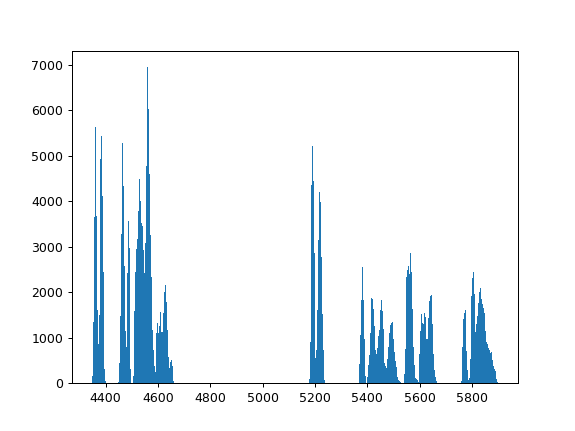

                                                     form  nvars  accuracy  \
123011  nxt ~ currentd + pval + relt + scsq + int + ti...      8  0.468676   
204092  nxt ~ currentd + pcr + pval + relt + scsq + in...      9  0.467734   
59564   nxt ~ currentd + pval + relt + scsq + int + ti...      7  0.465850   
116777  nxt ~ currentd + pcr + pval + relt + scsq + in...      8  0.469147   
289793  nxt ~ currentd + pct + pcr + pval + relt + scs...     10  0.470561   
211004  nxt ~ currentd + pval + relt + scsq + lrn + in...      9  0.472445   
289892  nxt ~ currentd + pct + pcr + pval + relt + scs...     10  0.471032   
122912  nxt ~ currentd + pval + relt + scsq + lrn + in...      8  0.471503   
197558  nxt ~ currentd + pct + pval + relt + scsq + lr...      9  0.469147   
197657  nxt ~ currentd + pct + pval + relt + scsq + in...      9  0.471503   

                AIC          BIC  
123011  4348.752075  4411.018515  
204092  4349.098588  4417.025613  
59564   4349.205692  4405.811546  
1

In [53]:
def modsel():
    data = pd.read_csv('R_docs/massive-ds_09-11-2018.csv').dropna()
    print(data.shape)
    lookat = 'AIC'
    x = data.loc[:, lookat]
    
    print(len(x))
    plt.hist(x, bins=500)
    
    print(data.sort_values(by=lookat, ascending=True).loc[:, ['form','nvars','accuracy','AIC','BIC']].head(10))
    
    
if 1:
    modsel()